In [164]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode

In [4]:
def process_video_data(features_path, labels_data):
    features_list = []
    labels_list = []
    empty_frame_count = 0
    empty_frame_ids = []

    for video_file in glob.glob(os.path.join(features_path, "*.npy")):
        video_id = os.path.basename(video_file).split("_")[0]
        feature_array = np.load(video_file)

        if feature_array.size == 0:
            empty_frame_count += 1
            empty_frame_ids.append(video_id)
            continue

        avg_feature = np.mean(feature_array, axis=0)
        features_list.append(avg_feature)

        label = labels_data[labels_data["youtube_id"] == video_id]["label"].values[0]
        labels_list.append(label)

    print(f"Number of empty videos not included ({features_path}): {empty_frame_count}")
    print(f"Labels of empty videos not included: {empty_frame_ids}")

    stacked_features = np.vstack(features_list)
    stacked_labels = np.vstack(labels_list)

    features_df = pd.DataFrame(stacked_features)
    labels_df = pd.DataFrame(stacked_labels)

    return features_df, labels_df



In [6]:

df_train_labels = pd.read_csv(
    "./data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)

X_train, Y_train = process_video_data(
    "./feature_results/train/r21d/r2plus1d_34_8_ig65m_ft_kinetics/", df_train_labels
)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")

# Concatenar DataFrames a lo largo de las columnas
train_data_extracted_df = pd.concat([X_train, Y_train], axis=1)

# Exportar a un archivo CSV
train_data_extracted_df.to_csv('./train_data_extracted.csv', index=False)

Number of empty videos not included (./feature_results/train/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para entrenamiento: 5415
Shape de nuestra matriz de videos para entrenamiento: (5415, 512)


In [7]:
X_val, Y_val = process_video_data(
    "./feature_results/val/r21d/r2plus1d_34_8_ig65m_ft_kinetics/", df_val_labels
)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

print(f"\nNúmero de videos cargados para validación: {len(X_val)}")
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")

# Concatenar DataFrames a lo largo de las columnas
val_data_extracted_df = pd.concat([X_val, Y_val], axis=1)

# Exportar a un archivo CSV
val_data_extracted_df.to_csv('./val_data_extracted.csv', index=False)

Number of empty videos not included (./feature_results/val/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


In [8]:
X_test, Y_test = process_video_data(
    "./feature_results/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/", df_test_labels
)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

# Concatenar DataFrames a lo largo de las columnas
test_data_extracted_df = pd.DataFrame(X_test)

# Exportar a un archivo CSV
test_data_extracted_df.to_csv('./test_data_extracted.csv', index=False)

Number of empty videos not included (./feature_results/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para testeo: 805
Shape de nuestra matriz de videos para testeo: (805, 512)


(5415, 100)


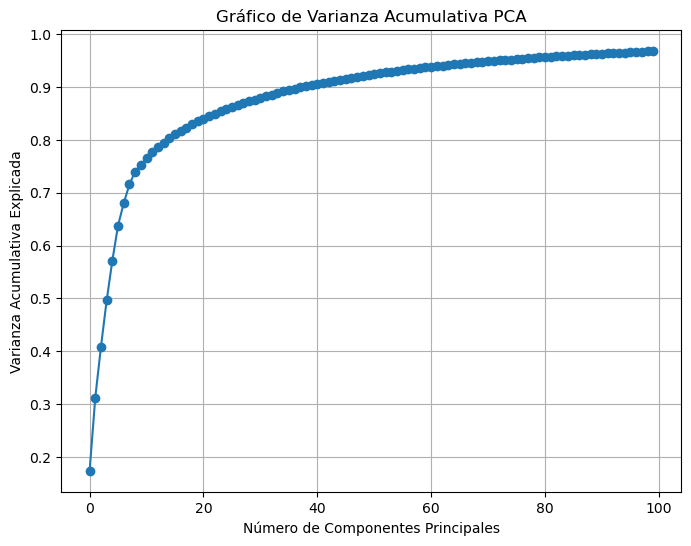

Number of unique values in Y_train: 10
{0: 'fixing hair', 1: 'baking cookies', 2: 'shot put', 3: 'dying hair', 4: 'stretching leg', 5: 'riding camel', 6: 'wrapping present', 7: 'flipping pancake', 8: 'spraying', 9: 'balloon blowing'}


In [251]:
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_train)
print(X_reduced.shape)

explained_variance = pca.explained_variance_ratio_
# Assuming 'explained_variance' is already defined
cumulative_variance = np.cumsum(explained_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

unique_values = np.unique(Y_train)
num_unique_values = len(unique_values)
print("Number of unique values in Y_train:", num_unique_values)

kmeans = KMeans(n_clusters=num_unique_values, random_state=0, n_init="auto").fit(X_reduced)

labels = kmeans.labels_
# Comparar las etiquetas de KMeans con Y_train
# Aquí asumimos que Y_train es un array de etiquetas reales
# Puedes usar cualquier método de comparación que sea relevante para tu caso

real_labels = np.array(Y_train)
#for i in range(len(Y_train)):
    #print("KMeans label:", kmeans_labels[i], " - Real label:", real_labels[i])

# Encontrar el valor más común de Y_train para cada grupo
cluster_to_y_value = {}
for cluster in np.unique(labels):
    indices = np.where(labels == cluster)[0]
    unique_values, counts = np.unique(real_labels[indices], return_counts=True)
    mode_index = np.argmax(counts)
    mode_value = unique_values[mode_index]
    cluster_to_y_value[cluster] = mode_value

print(cluster_to_y_value)





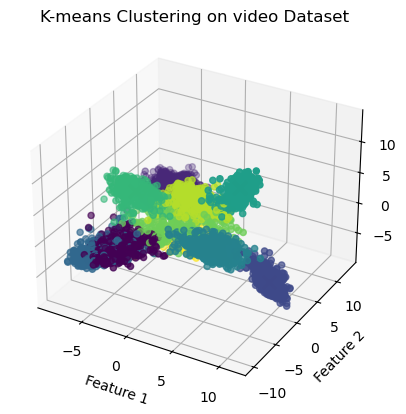

In [259]:
from matplotlib.animation import FuncAnimation
# Plot the data points and their cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           marker='x', color='red', s=100 , linewidths=3)
# Set light blue background 

ax.set_title("K-means Clustering on video Dataset")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

# Función de animación
def update(frame):
    ax.view_init(elev=10, azim=frame)
    return fig,

# Crear animación
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=50, blit=True)

plt.show()